In [1]:
from re import VERBOSE
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
# Load dataset
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteGVR11L/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Function to split dataset
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [5]:
# Ratios for train, validation, and test sets
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

In [6]:
# Split dataset
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [7]:
# Print example data
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

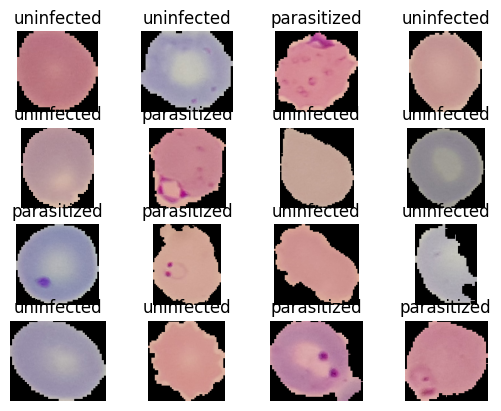

In [8]:
# Visualize example data
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
# Image size for resizing
IM_SIZE = 224

In [10]:
# Function to resize and rescale images
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [11]:
# Apply preprocessing to datasets
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [12]:
# Print example preprocessed data
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [13]:
# Batch size for training
BATCH_SIZE = 32

In [14]:
# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
# Define the model architecture
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),

    Dense(10, activation="relu"),
    BatchNormalization(),

    Dense(1, activation="sigmoid"),
])


In [16]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [17]:
# Define example labels and predictions for Binary Crossentropy loss
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 0]

In [18]:
# Compute Binary Crossentropy loss
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1007609>

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [20]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
517/517 [==============================] - 46s 76ms/step - loss: 0.6278 - accuracy: 0.6590 - val_loss: 7.8328 - val_accuracy: 0.4986
Epoch 2/20
517/517 [==============================] - 44s 85ms/step - loss: 0.5574 - accuracy: 0.7222 - val_loss: 10.3776 - val_accuracy: 0.4990
Epoch 3/20
517/517 [==============================] - 40s 76ms/step - loss: 0.5857 - accuracy: 0.6923 - val_loss: 0.6309 - val_accuracy: 0.6487
Epoch 4/20
517/517 [==============================] - 40s 77ms/step - loss: 0.6422 - accuracy: 0.6112 - val_loss: 1.1441 - val_accuracy: 0.5064
Epoch 5/20
517/517 [==============================] - 40s 76ms/step - loss: 0.6784 - accuracy: 0.5764 - val_loss: 1.1744 - val_accuracy: 0.5175
Epoch 6/20
517/517 [==============================] - 42s 81ms/step - loss: 0.6697 - accuracy: 0.5938 - val_loss: 0.7072 - val_accuracy: 0.4986
Epoch 7/20
517/517 [==============================] - 38s 73ms/step - loss: 0.6689 - accuracy: 0.6009 - val_loss: 0.6675 - val_accuracy

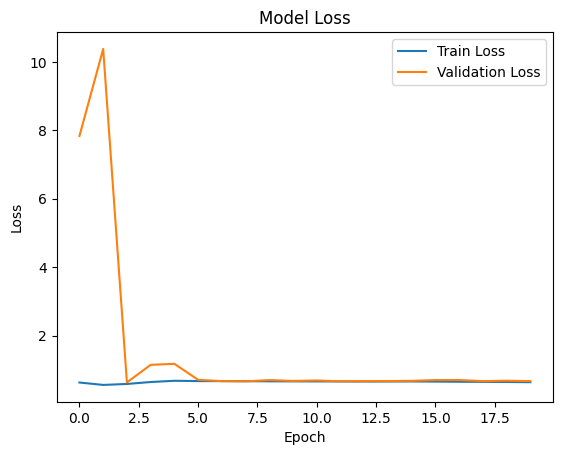

In [21]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

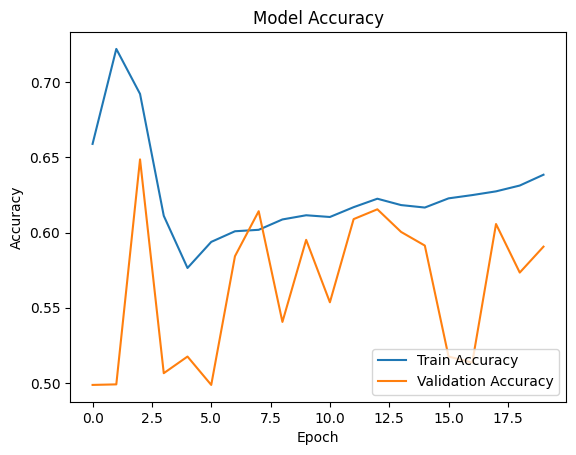

In [22]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [23]:
# MODEL EVALUATION AND TESTING
test_dataset = test_dataset.batch(1)
test_dataset
model.evaluate(test_dataset)

5513/5513 [==============================] - 29s 3ms/step - loss: 0.6672 - accuracy: 0.5893


[0.6672363877296448, 0.5893343091011047]

In [24]:
# Define the function to determine parasite or not
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'

In [25]:
# MODEL PREDICTIONS
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'P'

In [26]:

# Function to determine parasite or not
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'

1/1 [==============================] - 0s 18ms/step


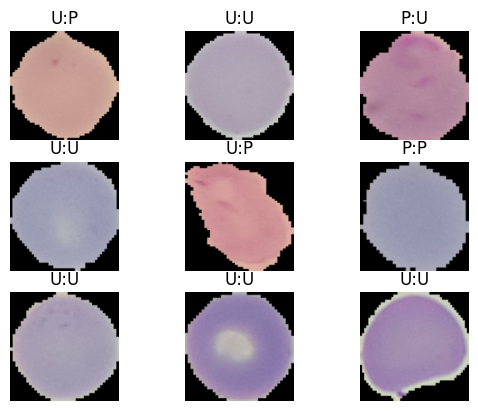

In [27]:
# Predictions and visualization
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(f'{parasite_or_not(label.numpy()[0])}:{parasite_or_not(model.predict(image)[0][0])}')
    plt.axis('off')
plt.show()
